In [ ]:
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

import gensim

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import json
import pandas as pd
import numpy as np

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data loading

In [ ]:
df_train = pd.read_json('project_training.json')
df_test = pd.read_json('project_validation.json')

### Define rule-based classifier

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

# RuleBasedClassifier- self-defined Classifier
# k: frequent words; x: related words; y: classification
class RuleBasedClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, k=50, preprocessor=None, vectorizer_cls=CountVectorizer):
        self.k = k
        self.preprocessor = preprocessor
        self.vectorizer_cls = vectorizer_cls

    def get_params(self, deep=True):
        return {
              'k': self.k,
              'preprocessor': self.preprocessor,
              'vectorizer_cls': self.vectorizer_cls
          }

    def fit(self, X, y, **kwargs):
        # store the most k frequent words as the related words for each class
        if y is None:
          raise ValueError('requires y to be passed, but the target y is None')

        self.classes_ = unique_labels(y)
        self.is_fitted_ = True
        self.n_features_in_ = 0
        
        vectorizer = self.vectorizer_cls(preprocessor=self.preprocessor)
        count_matrix = vectorizer.fit_transform(X)
        features = vectorizer.get_feature_names_out()
        self.labels = unique_labels(y)
        self.frequent_words_ = {}
        for label in self.labels:
            word_counts = count_matrix[y == label].toarray().sum(axis=0).ravel()
            # sort by count
            idx = np.argsort(word_counts)[::-1]
            # store the top k frequent words for each class
            frequent_words = features[idx][:self.k]
            self.frequent_words_[label] = frequent_words
        return self

    def predict(self, X):
        # count the related words for each class, return the class with max number of related words
        check_is_fitted(self, ['is_fitted_'])
        counts = []
        for label in self.labels:
            frequent_words = self.frequent_words_[label]
            count_matrix = self.vectorizer_cls(preprocessor=self.preprocessor, vocabulary=frequent_words).fit_transform(X)
            counts.append(count_matrix.toarray().sum(axis=1))
        # each column has total counts for their related words
        counts = np.column_stack(counts)
        max_col = np.argmax(counts, axis=1)
        return self.labels[max_col]




### Define preprocessing steps

In [ ]:
from functools import partial

nltk_stopwords = set(stopwords.words("english"))

gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS


wordnet_lemmatizer = WordNetLemmatizer()
snow_stemmer = SnowballStemmer(language='english')

# filters: which words are filtered/ removed (e.g. stopwords)
# mappers: for switching the words (e.g. lower-case)
def preprocessor_fn(text, tokenizer=RegexpTokenizer(r'\w+'), filters=None, mappers=None):
    words = tokenizer.tokenize(text)
    if filters:
        for f in filters:
            words = [word for word in words if f(word)]
    if mappers:
        for f in mappers:
            words = [f(word) for word in words]
    return ' '.join(words)

In [ ]:
preprocessors = {
    'baseline': partial(preprocessor_fn),
    'lowercase': partial(preprocessor_fn, mappers=[lambda x: x.lower()]),
    'nltk_stopwords': partial(preprocessor_fn, filters=[lambda x: x not in nltk_stopwords]),
    'gensim_stopwords': partial(preprocessor_fn, filters=[lambda x: x not in gensim_stopwords]),
    'snow_stemmer': partial(preprocessor_fn, mappers=[snow_stemmer.stem]),
    'wordnet_lemmatizer': partial(preprocessor_fn, mappers=[wordnet_lemmatizer.lemmatize]),
}

### Deciding whether include different steps

In [ ]:
from sklearn.model_selection import GridSearchCV

cv_results = []
for preprocessing, preprocessor in preprocessors.items():
    for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
        df = df_train[df_train[y_col].notnull()]
        X_train = df['text']
        y_train = df[y_col]
        
        #In order to maintain the fairness of selecting the words, default k = 200 first
        parameters = {'k': [200]}
        model = RuleBasedClassifier(preprocessor=preprocessor)
        # cross validation
        cv = GridSearchCV(model, parameters, cv=5, scoring='f1_macro', n_jobs=-1)
        cv.fit(X_train, y_train)

        # print(cv.best_params_)
        # print(cv.best_score_)
        # ((preprocessing, y_col, cv.best_score_)) ; take the best score as final
        cv_results.append((preprocessing, y_col, cv.best_score_))

df_cv = pd.DataFrame(cv_results, columns=['preprocessing', 'case', 'f1_macro'])

In [ ]:
df_cv

,preprocessing,case,f1_macro
0,baseline,climate,0.729718
1,baseline,sentiment,0.700868
2,baseline,commitment,0.718767
3,baseline,specificity,0.711149
4,lowercase,climate,0.737166
5,lowercase,sentiment,0.685596
6,lowercase,commitment,0.773045
7,lowercase,specificity,0.734005
8,nltk_stopwords,climate,0.729563
9,nltk_stopwords,sentiment,0.730345


In [ ]:
def annotate_bars(ax=None, fmt='.2f', **kwargs):
    ax = plt.gca() if ax is None else ax
    for p in ax.patches:
         ax.annotate('{{:{:s}}}'.format(fmt).format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),textcoords='offset points',
                     ha='center', va='center', **kwargs)

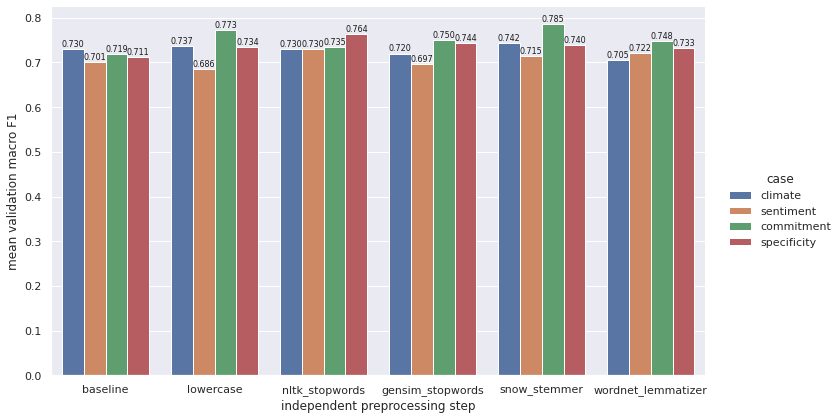

In [ ]:
ax = sns.catplot(
    data=df_cv, kind="bar",
    x="preprocessing", y="f1_macro", hue="case", height=6, aspect=1.7, 
)
ax.map(annotate_bars, fmt='.3f', fontsize=8, color='k')
ax.set_axis_labels("independent preprocessing step", "mean validation macro F1")

### Finding best k and evaluating the test data



In [ ]:
from sklearn.metrics import f1_score

f1_marco_score = partial(f1_score, average='macro')

test_results = []

self_defined_stopwords = set({'the', 'includ', 'in', 'also', 'we',  'may', 
              'use', 'this', 'bank', 'could','term', 'our', 'due', 'as', 'us', 'mine', 'it', 'oper', 
              'our', 'mine', 'metric', 'continu', 'team', 'two', 'across', 
              'kic', 'ghg', 'https', 'tilt', 'first', '000', 'per', 'period', 'sector', 
              'next', 'three',  'one', 'www', 'line', 'for', 'due', 'uk', 
              'sinc',  'bank', 'zero',  'four', 'all', '50', 'with', 'save',  'mw',  'relat', 
              'higher', 'long', 'issu', 'need', 'these', 'model', 'mani', 'there', 'subject', 'etc',
              'becom', 'total', 'tonn', 'world', 'client',  'sourc', 'mix', 'toward', 'around', 'medium', 
              'tool', 'phase', 'area', 'farm', 'ghg', 'level', 'net', 'unit', 'esg','show', 'page', 
              'larg', 'usd', 'way', 'within', 'countri', '15', 'follow',
              'iag', 'short', 'sign', 'even', 'overal', 'five', 'home', 'these', '40', 'made', 'juli',
               'station', 'to', 'america', '25', 'third', 'exampl', '23', 'at', 'fire', 
              'without', 'give', 'make', 'mbank', 'peopl', 'asia', 'chain', 'research'})

self_defined_stopwords.update(nltk_stopwords)

# After comparing the independent preprocessing method, we use NLTK_Stopwords; Snow_stemmer and lowercase
preprocessor = partial(preprocessor_fn, 
                       filters=[lambda x: x not in self_defined_stopwords], 
                       mappers=[lambda x: x.lower(),
                                snow_stemmer.stem,
                               ])
best_estimators = {}
for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
    df = df_train[df_train[y_col].notnull()]
    X_train = df['text']
    y_train = df[y_col]
    
    # Then find the best k! 
    # range(20, 401, 10): to find in range 20 to 400; increasing 10 words each time
    parameters = {'k': range(20, 401, 10)}
    model = RuleBasedClassifier(preprocessor=preprocessor)
    # cross validation (to find the best k)
    # one k tries 5 times (cv=5); we tried (400-20)*5 times
    cv = GridSearchCV(model, parameters, cv=5, scoring='f1_macro', n_jobs=-1)
    cv.fit(X_train, y_train)
    best_estimators[y_col] = cv.best_estimator_
    # use the best model for prediction 
    # After choosing besk k and best pre-processing method
    df = df_test[df_test[y_col].notnull()]
    X_test = df['text']
    y_test = df[y_col]
    y_pred = cv.best_estimator_.predict(X_test)
    score = f1_marco_score(y_test, y_pred)
    # score = f1_marco_score(y_train, cv.best_estimator_.predict(X_train))
    report = classification_report(y_test, y_pred)
    test_results.append((y_col, score, report, cv.best_params_['k']))

df_results = pd.DataFrame(test_results, columns=['case', 'test_f1_macro', 'report', 'k'])

In [ ]:
for report in df_results['report'].values:
  print(report)

              precision    recall  f1-score   support

          no       0.57      0.61      0.59        71
         yes       0.91      0.90      0.91       329

    accuracy                           0.85       400
   macro avg       0.74      0.75      0.75       400
weighted avg       0.85      0.85      0.85       400

              precision    recall  f1-score   support

     neutral       0.61      0.68      0.65       136
 opportunity       0.61      0.64      0.63        81
        risk       0.79      0.65      0.72       112

    accuracy                           0.66       329
   macro avg       0.67      0.66      0.66       329
weighted avg       0.67      0.66      0.66       329

              precision    recall  f1-score   support

          no       0.86      0.76      0.80       190
         yes       0.71      0.83      0.77       139

    accuracy                           0.79       329
   macro avg       0.79      0.79      0.79       329
weighted avg       0

In [ ]:
for label, best_estimator in best_estimators.items():
    print(label)
    print(best_estimator.frequent_words_)

climate
{'no': array(['risk', 'manag', 'busi', 'oper', 'year', 'invest', 'group',
       'compani', 'the', 'in', 'includ', 'market', 'billion', 'board',
       'impact', 'financi', 'we', 'capit', 'complianc', 'develop',
       'report', 'assess', 'base', 'intern', 'result', 'new', 'system',
       'potenti', 'identifi', 'servic', 'asset', 'time', 'execut',
       'custom', 'bank', 'reput', 'valu', 'this', 'financ', 'inform',
       'govern', 'requir', 'addit', 'strateg', 'perform', '2020',
       'continu', '2021', 'project', 'annual', 'futur', 'loss', 'price',
       'process', 'profit', 'organ', 'share', 'respons', '2019', 'plan',
       'fund', 'aim', 'industri', 'strategi', 'revenu', 'regulatori',
       'opportun', 'it', 'well', 'stakehold', 'type', 'initi', 'safeti',
       'increas', 'basi', 'control', 'relat', 'technolog', 'focus',
       'consid', 'test', 'polici', 'effect', 'corpor', 'failur',
       'support', 'factor', 'capac', 'for', 'data', 'end', 'chang',
       'employe

In [ ]:
df_results

,case,test_f1_macro,report,k
0,climate,0.748649,precision recall f1-score ...,160
1,sentiment,0.662675,precision recall f1-score ...,190
2,commitment,0.785568,precision recall f1-score ...,130
3,specificity,0.725162,precision recall f1-score ...,40


Text(0, 0.5, 'test macro F1')

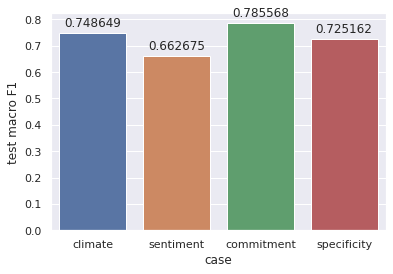

In [ ]:
ax = sns.barplot(data=df_results, x="case", y="test_f1_macro")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax.set_ylabel("test macro F1")

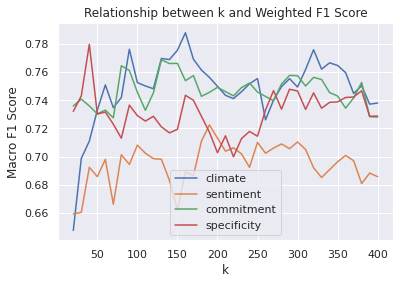

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

self_defined_stopwords = set({'the', 'includ', 'in', 'also', 'we',  'may', 
              'use', 'this', 'bank', 'could','term', 'our', 'due', 'as', 'us', 'mine', 'it', 'oper', 
              'our', 'mine', 'metric', 'continu', 'team', 'two', 'across', 
              'kic', 'ghg', 'https', 'tilt', 'first', '000', 'per', 'period', 'sector', 
              'next', 'three',  'one', 'www', 'line', 'for', 'due', 'uk', 
              'sinc',  'bank', 'zero',  'four', 'all', '50', 'with', 'save',  'mw',  'relat', 
              'higher', 'long', 'issu', 'need', 'these', 'model', 'mani', 'there', 'subject', 'etc',
              'becom', 'total', 'tonn', 'world', 'client',  'sourc', 'mix', 'toward', 'around', 'medium', 
              'tool', 'phase', 'area', 'farm', 'ghg', 'level', 'net', 'unit', 'esg','show', 'page', 
              'larg', 'usd', 'way', 'within', 'countri', '15', 'follow',
              'iag', 'short', 'sign', 'even', 'overal', 'five', 'home', 'these', '40', 'made', 'juli',
               'station', 'to', 'america', '25', 'third', 'exampl', '23', 'at', 'fire', 
              'without', 'give', 'make', 'mbank', 'peopl', 'asia', 'chain', 'research'})

self_defined_stopwords.update(nltk_stopwords)

weighted_f1_scores = {}

for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
    df = df_train[df_train[y_col].notnull()]
    X_train = df['text']
    y_train = df[y_col]
    preprocessor = partial(preprocessor_fn, 
                           filters=[lambda x: x not in self_defined_stopwords], 
                           mappers=[lambda x: x.lower(),
                                    snow_stemmer.stem,
                                   ])
    
    weighted_f1_scores[y_col] = []
    
    for k in range(20, 401, 10):

        clf = RuleBasedClassifier(k=k, preprocessor=preprocessor)
        f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
        weighted_f1_score = f1_scores.mean()
        weighted_f1_scores[y_col].append(weighted_f1_score)

    # Plot the k values against the f1 scores
    plt.plot(range(20, 401, 10), weighted_f1_scores[y_col], label=y_col)

plt.xlabel('k')
plt.ylabel('Macro F1 Score')
plt.title('Relationship between k and Weighted F1 Score')
plt.legend()
plt.show()


## Cross Validation for 4 Classification

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

f1_macro_score = partial(f1_score, average='macro')

self_defined_stopwords = set({'the', 'includ', 'in', 'also', 'we',  'may', 
              'use', 'this', 'bank', 'could','term', 'our', 'due', 'as', 'us', 'mine', 'it', 'oper', 
              'our', 'mine', 'metric', 'continu', 'team', 'two', 'across', 
              'kic', 'ghg', 'https', 'tilt', 'first', '000', 'per', 'period', 'sector', 
              'next', 'three',  'one', 'www', 'line', 'for', 'due', 'uk', 
              'sinc',  'bank', 'zero',  'four', 'all', '50', 'with', 'save',  'mw',  'relat', 
              'higher', 'long', 'issu', 'need', 'these', 'model', 'mani', 'there', 'subject', 'etc',
              'becom', 'total', 'tonn', 'world', 'client',  'sourc', 'mix', 'toward', 'around', 'medium', 
              'tool', 'phase', 'area', 'farm', 'ghg', 'level', 'net', 'unit', 'esg','show', 'page', 
              'larg', 'usd', 'way', 'within', 'countri', '15', 'follow',
              'iag', 'short', 'sign', 'even', 'overal', 'five', 'home', 'these', '40', 'made', 'juli',
               'station', 'to', 'america', '25', 'third', 'exampl', '23', 'at', 'fire', 
              'without', 'give', 'make', 'mbank', 'peopl', 'asia', 'chain', 'research'})

self_defined_stopwords.update(nltk_stopwords)

test_results = []

preprocessor = partial(preprocessor_fn, 
                       filters=[lambda x: x not in self_defined_stopwords],
                       mappers=[lambda x: x.lower(),
                                snow_stemmer.stem,
                               ])
best_estimators = {} 

for y_col in ['climate', 'sentiment', 'commitment', 'specificity']:
    df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)
    df = df_combined[df_combined[y_col].notnull()]
    X = df['text']
    y = df[y_col]
    
    parameters = {'k': range(20, 401, 10)}
    model = RuleBasedClassifier(preprocessor=preprocessor)
    cv = GridSearchCV(model, parameters, cv=5, scoring='f1_macro', n_jobs=-1)
    cv.fit(X, y)
    
    best_k = cv.best_params_['k']
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = RuleBasedClassifier(preprocessor=preprocessor, k=best_k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1_scores.append(f1_macro_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='macro'))
        recall_scores.append(recall_score(y_test, y_pred, average='macro'))
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    mean_f1_score = np.mean(f1_scores)
    mean_precision_score = np.mean(precision_scores)
    mean_recall_score = np.mean(recall_scores)
    mean_accuracy_score = np.mean(accuracy_scores)

    test_results.append((y_col, mean_f1_score, mean_precision_score, mean_recall_score, mean_accuracy_score, best_k))

df_results = pd.DataFrame(test_results, columns=['case', 'test_f1_macro', 'test_precision', 'test_recall', 'test_accuracy', 'k'])


In [ ]:
df_results

,case,test_f1_macro,test_precision,test_recall,test_accuracy,k
0,climate,0.780443,0.775066,0.796633,0.867500,390
1,sentiment,0.708367,0.717214,0.706471,0.708066,170
2,commitment,0.761552,0.762903,0.766966,0.763944,100
3,specificity,0.729506,0.728302,0.733548,0.735293,80


Text(0, 0.5, 'test macro F1')

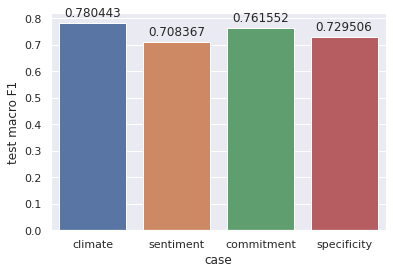

In [ ]:
#ax = sns.barplot(data=df_results, x="case", y="test_f1_macro")
ax = sns.barplot(data=df_results, x="case", y="test_f1_macro")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax.set_ylabel("test macro F1")